# NEGF Transistor sim 
Contains code from Chien-Ting Tung to check 
Single orbital, 1D NEGF 

In [1]:
# DeviceStructure.py
import numpy as np
import scipy.constants as spc

class DeviceStructure:
    def __init__(self):
        # Physical constants
        self.T = 300  # Kelvin
        self.kbT = spc.Boltzmann * self.T
        self.q = spc.e
        self.hbar = spc.hbar
        self.m = 0.45 * spc.m_e
        self.epsl = 8.854e-12 * 3.3
        self.epox = 8.854e-12 * 3.9

        # Geometry parameters
        self.a = 2.5e-10  # discretization spacing (m)
        self.L = 4e-9   # channel length (m)
        self.sd = 2e-9  # source/drain length (m)
        self.sp = 0     # spacer length (m)
        self.tox = 0.5e-9 # thickness of oxide layer
        self.Tch = 5.e-10 # thickness of the channel
        
        self.V_S = 0
        self.V_D = 0

        # Derived discretization parameters
        self.NL = int(np.ceil(self.L / self.a)) # total nuumber of atoms in channel 
        self.NSD = int(np.ceil(self.sd / self.a))
        self.NSP = int(np.ceil(self.sp / self.a))
        self.Nx = self.NL + 2 * (self.NSD + self.NSP) # total number of atoms in device (x direction only)
        self.x = np.linspace(0, (self.Nx - 1) * self.a, self.Nx) 

        # Density of states parameters
        self.n2d = (2 * self.m * self.kbT) / (self.hbar**2 * np.pi * 2) 
        self.n1d = 2 * np.sqrt(self.m * self.kbT / (self.hbar**2 * np.pi * 2))
        self.Nc = self.n2d

        #hamiltonian
        self.t0 = self.hbar**2/(2*self.m*self.a**2*self.q) # 
        self.H00 = np.array([[2 * self.t0]]) 
        self.H10 = np.array([[-self.t0]]) # coupling energy between leads and channel 
        self.orbitals = 1 # how many orbitals each atom has, for exam
        # Doping profile
        self.NB = 2*self.Nc*np.concatenate([
            np.ones(self.NSD), 
            np.zeros(self.NSP), 
            np.zeros(self.NL), 
            np.zeros(self.NSP), 
            np.ones(self.NSD)])

        # Flat-band voltage and barrier height
        self.VFB, self.phib = 0.35, 0.05

        # Voltage sweeps
        VV=21
        self.Vds=np.linspace(0,0.5,VV)
        self.Vgs=np.linspace(0,0.5,VV)
        
        self.nn = np.zeros((VV,VV,self.Nx))
        self.qg = np.zeros((VV,VV))



In [2]:
class Helper_functions:
    
    # Define F_1/2(x)
    def FD_half(x):
        '''
        Approximation of the Fermi-Dirac integral of order 1/2.
        Reference: http://dx.doi.org/10.1063/1.4825209
        '''
        v = x**4 + 50 + 33.6 * x * (1 - 0.68 * np.exp(-0.17 * (x + 1)**2))
        return 1 / (np.exp(-x) + 3 * np.pi**0.5 / 4 * v**(-3/8))

    # Define F_-1/2(x) as the derivative of F_1/2(x)
    def FD_minus_half(x):
        dx = x * 1e-6  
        return (Helper_functions.FD_half(x + dx) - Helper_functions.FD_half(x - dx)) / (2 * dx)

    def sparse_diag_product(A, B):
        """
        Compute diagonal elements of C = A * B efficiently for sparse matrices.

        Parameters:
            A (csr_matrix): sparse matrix in CSR format
            B (csc_matrix): sparse matrix in CSC format

        Returns:
            numpy.ndarray: diagonal elements of A*B
        """
        from scipy.sparse import csr_matrix, csc_matrix
        import numpy as np

        # Ensure A is CSR and B is CSC for efficient indexing
        if not isinstance(A, csr_matrix):
            A = csr_matrix(A)
        if not isinstance(B, csc_matrix):
            B = csc_matrix(B)

        n = A.shape[0]
        diag = np.zeros(n, dtype=complex)

        for i in range(n):
            # Get row i from A (CSR format)
            A_row_start, A_row_end = A.indptr[i], A.indptr[i+1]
            A_cols = A.indices[A_row_start:A_row_end]
            A_vals = A.data[A_row_start:A_row_end]

            # Get column i from B (CSC format)
    
            B_rows = B.indices[B.indptr[i]:B.indptr[i+1]]
            B_vals = B.data[B.indptr[i]:B.indptr[i+1]]

            # Compute intersection of indices efficiently
            ptr_a, ptr_b = 0, 0
            sum_diagonal = 0.0
            while ptr_a < len(A_cols) and ptr_b < len(B_rows):
                col_a, row_b = A_cols[ptr_a], B_rows[ptr_b]
                if col_a == row_b:
                    sum_diagonal += A_vals[ptr_a] * B_vals[ptr_b]
                    ptr_a += 1
                    ptr_b += 1
                elif col_a < row_b:
                    ptr_a += 1
                else:
                    ptr_b += 1

            diag[i] = sum_diagonal

        return diag



In [3]:
# Hamiltonian.py
import numpy as np

class Hamiltonian:
    def __init__(self, device_state):
        self.device_state=device_state

    def create_hamiltonian(self, Ec):
        t0=self.device_state.t0
        Nx=self.device_state.Nx
        D2=-2*np.eye(Nx)+np.eye(Nx,k=1)+np.eye(Nx,k=-1)
        
        H=-t0*D2+np.diag(Ec/self.device_state.q) # Ec in Joules converted to eV
        
        self.device_state.H = H
        return H
    
    def print_hamiltonian(self):
        t0=self.device_state.t0
        Nx=self.device_state.Nx
        D2=-2*np.eye(Nx)+np.eye(Nx,k=1)+np.eye(Nx,k=-1)
        
        H=-t0*D2
        
        self.device_state.H = H
        return H
    

            


In [4]:
# GreensFunction.py
import numpy as np

class GreensFunction:
    def __init__(self, device_state):
        self.ds=device_state
        self.eta = 1e-12j
    
    def compute_GF(self,E,H,t0,Ec,Vds): # old way of doing rgf (analytic solution)
        
        Nx=self.ds.Nx; q=self.ds.q; hbar=self.ds.hbar; a=self.ds.a
        
        zplus=1j*1e-12
        
        ka1=np.arccos(1-(E+zplus-Ec[0]/q)/(2*t0))
        ka2=np.arccos(1-(E+zplus-Ec[-1]/q)/(2*t0))
        
        sig1=np.zeros((Nx,Nx),dtype=complex); sig1[0,0]=-t0*np.exp(1j*ka1); gam1=1j*(sig1-sig1.conj().T)
        
        sig2=np.zeros((Nx,Nx),dtype=complex); sig2[-1,-1]=-t0*np.exp(1j*ka2); gam2=1j*(sig2-sig2.conj().T)
        
        G=np.linalg.inv((E+zplus)*np.eye(Nx)-H-sig1-sig2)
        A = (E+zplus)*np.eye(Nx)-H-sig1-sig2
       
        #print(sig1, sig2)
        return G,gam1,gam2,sig1,sig2
    
    def rgf(self, E, Ec): #recursive solution based on the 
        E = E + self.eta
        ds = self.ds
        H = ds.H
        dagger = lambda A: np.conjugate(A.T)
        f_s = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - ds.V_S) / (ds.kbT))
        f_d = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - ds.V_D) / (ds.kbT))
        fermi = lambda x,y: 1 / (1 + np.exp((x-y) / (ds.kbT  /ds.q)))
        
        sigmaL,sigmaR = self.self_energy(E,Ec)
        
        self_energy_right = np.zeros_like(H, dtype=complex)
        self_energy_left = np.zeros_like(H, dtype=complex)
        
        self_energy_size = sigmaR.shape[0]
        self_energy_right[-self_energy_size:,-self_energy_size:] = sigmaR
        self_energy_left[0:self_energy_size,0:self_energy_size] = sigmaL
        
        
        gamma1 = 1j * (self_energy_left - dagger(self_energy_left))
        gamma2 = 1j * (self_energy_right - dagger(self_energy_right))
        self_energy_lesser = gamma1 * f_s +  gamma2 * f_d
        
        sigma_less_left = gamma1 * f_s
        sigma_less_right = gamma2 * f_d
        block_size = ds.orbitals
        print(self_energy_left[0,0], self_energy_right[-1,-1])
  
        
        
        N = H.shape[0]
        num_blocks = N // block_size
        
        E_matrix = np.eye(N, dtype=complex) * (E)
        A = E_matrix - H - self_energy_left - self_energy_right
        
        
        # Initialize arrays (this style of storing data was taken from jiezi program)
        g_R_blocks = []
        g_lesser_blocks = []

        
        G_R = [None] * num_blocks
        G_R_1 = [None] * (num_blocks - 1)
        G_lesser = [None] * num_blocks
        G_lesser_1 = [None] * (num_blocks - 1)
        
        # Forward recursion: Calculate diagonal blocks of g_R
        for i in range(num_blocks):
            start = i * block_size
            end = (i+1) * block_size
            prev = (i - 1) * block_size
            if i == 0:
                # First block
                g_0_r = np.linalg.inv(A[start:end, start:end])
                g_R_blocks.append(g_0_r)
                #g_lesser
                g_0_lesser = g_0_r @ self_energy_lesser[start:end, start:end] @ dagger(g_0_r)
                g_lesser_blocks.append(g_0_lesser)
            else:          
                
                H_eff = A[start:end, start:end] - A[start:end, prev:start] @ g_R_blocks[i-1] @ A[prev:start, start:end]
                g_R_blocks.append(np.linalg.inv(H_eff))

                #g_i_lesser calculation
                sigma_lesser = A[start:end, prev:start] @ g_lesser_blocks[i - 1] @ dagger(A[prev:start, start:end])
                g_i_lesser = g_R_blocks[i] @ (self_energy_lesser[start: end, start: end] + sigma_lesser - \
                    self_energy_lesser[start:end, prev:start] @ dagger(g_R_blocks[i - 1]) @ dagger(A[prev:start, start:end]) - \
                        A[start:end, prev:start] @ g_R_blocks[i-1] @ self_energy_lesser[prev:start, start:end]) @ dagger(g_R_blocks[i])
                g_lesser_blocks.append(g_i_lesser)        

        G_R[-1] = g_R_blocks[-1]
        G_lesser[-1] = g_lesser_blocks[-1]

        for i in reversed(range(num_blocks - 1)):
            start = i * block_size
            end = (i+1)*block_size
            after = (i+2)*block_size

            
            # Dyson equation for current block
            G_R[i] = g_R_blocks[i] @ (np.eye(block_size) + 
            A[start:end, end:after]@G_R[i+1]@A[end:after, start:end]@g_R_blocks[i])
            
            G_R_1[i] = -G_R[i + 1] @ A[end:after, start:end] @ g_R_blocks[i]
            
        
            #lesser function
            
            gr0 = np.linalg.inv(E * np.eye(block_size) - H[start:end, start:end]) 
            ga0 = dagger(gr0)
            gr1 = np.linalg.inv(E * np.eye(block_size) - H[end:after, end:after])
            ga1 = dagger(gr1)
            gqq1 = gr0 @ self_energy_lesser[start:end, end:after] @ ga1
            gq1q = gr1 @ self_energy_lesser[end:after, start:end] @ ga0 
            
            G_i_lesser = g_lesser_blocks[i] + g_R_blocks[i] @ (A[start:end, end:after] @ G_lesser[i + 1] @ dagger(A[end:after, start:end])) @ dagger(g_R_blocks[i]) - \
                (g_lesser_blocks[i] @ A[end:after, start:end] @ dagger(G_R_1[i].T) + G_R_1[i].T @ A[end:after, start:end] @ g_lesser_blocks[i]) - \
                    (gqq1 @ dagger(A[end:after, start:end]) @ dagger(G_R[i]) + G_R[i] @ A[start:end, end:after] @ gq1q)
            
            G_lesser[i] = G_i_lesser
            
            G_i_lesser_1 = gq1q - G_R_1[i] @ A[start:end, end:after] @ gq1q - G_R[i+1] @ A[end:after,start:end] @ g_lesser_blocks[i] - \
                G_lesser[i+1] @ dagger(A[end:after,start:end]) @ dagger(g_R_blocks[i])
            
            G_lesser_1[i] = G_i_lesser_1[0]
            
            
        G_R = np.diag(np.ravel(G_R).flatten())
        G_lesser = np.diag(np.ravel(G_lesser).flatten())
    
        return G_R, G_lesser, gamma1, gamma2, sigma_less_left, sigma_less_right
    
    
        """diagonals = [np.diag(block) for block in G_lesser]  # Extract diagonals 
        G_lesser = np.concatenate(diagonals, dtype=complex)  # Concatenate all diagonals 

        diagonals = [np.diag(block) for block in G_R]  # Extract diagonals 
        G_R = np.concatenate(diagonals, dtype=complex)  # Concatenate all diagonals 
        
        return G_R, G_lesser, gamma1, gamma2, sigma_less_left, sigma_less_right"""
    
    def surface_gf(self, Energy, tol=1e-6): #right now this is only tested for 1D
        device_state = self.ds
        Energy = Energy
        H00 = device_state.H00
        H10 = device_state.H10
        dagger = lambda A: np.conjugate(A.T)
        I = np.eye(H00.shape[0], dtype=complex)
        H01 = dagger(H10)

        epsilon_s = H00.copy()
        epsilon = H00.copy()
        alpha = H01.copy()
        beta = dagger(H10).copy()
        err = 1.0

        while err > tol:
            inv_E = np.linalg.inv(Energy * I - epsilon)
            epsilon_s_new = epsilon_s + alpha @ inv_E @ beta
            epsilon_new = epsilon + beta @ inv_E @ alpha + alpha @ inv_E @ beta
            alpha_new = alpha @ inv_E @ alpha
            beta_new = beta @ inv_E @ beta

            err = np.linalg.norm(alpha_new, ord='fro')

            epsilon_s, epsilon, alpha, beta = epsilon_s_new, epsilon_new, alpha_new, beta_new

        return np.linalg.inv(Energy * I - epsilon_s)
    def self_energy(self, E, Ec):
        dagger = lambda A: A.conj().T
        
        # Surface Green's functions at left and right leads
        
        G_surf_left = self.surface_gf(E - Ec[0] / self.ds.q)
        G_surf_right = self.surface_gf(E - Ec[-1] / self.ds.q)

        # Coupling matrices
        H10 = self.ds.H10
        H01 = dagger(H10)
        
        # Self-energy calculation (Σ = τ g τ†)
        sigma_left = H01 @ G_surf_left @ H10
        sigma_right = H10 @ G_surf_right @ H01
        #print(sigma_left, sigma_right)
        return sigma_left, sigma_right


In [5]:
# PoissonSolver.py
import numpy as np

class PoissonSolver:
    """
    This class contains the methods to solve Poisson's equation. It takes the conduction band edge energy, 
    
    """
    def __init__(self, device_state):
        self.ds=device_state
    
    def fermi_dirac(self,eta):
        return np.log(1+np.exp(eta))

    def solve_poisson(self,Vg,Efn):
        
        Ec=Efn.copy(); error=1; iter_count=0; ds=self.ds
        
        
        while error>1e-4 and iter_count<100:
            
            eta=(Efn-Ec)/ds.kbT
            
            n0=ds.Nc*self.fermi_dirac(eta)
            dn0=ds.Nc/ds.kbT*(np.exp(eta)/(1+np.exp(eta)))
            
            B=-ds.q**2*ds.a/ds.epsl
            
            D2=-2*np.eye(ds.Nx)+np.eye(ds.Nx,k=1)+np.eye(ds.Nx,k=-1)
            
            D2y=np.concatenate([
                np.zeros(ds.NSD+ds.NSP),
                -2*ds.epox*ds.a**2/(ds.epsl*ds.tox*ds.Tch)*np.ones(ds.NL),
                np.zeros(ds.NSD+ds.NSP)])
            
            D2p=D2+np.diag(D2y); D2p[0,0]=D2p[-1,-1]=-1
            
            LHS=D2p+np.diag(B*dn0)
            
            RHS=-D2p@Ec+B*(n0-ds.NB)+\
                (2*ds.q*ds.epox*ds.a**2/(ds.epsl*ds.tox*ds.Tch))*Vg
            
            delta=np.linalg.solve(LHS,RHS); Ec+=delta
            
            error=np.max(np.abs(delta/ds.q)); iter_count+=1
        
        
        return Ec,n0


In [6]:
import numpy as np
import matplotlib.pyplot as plt


class MainSolver:
    def __init__(self):
        self.ds = DeviceStructure()
        self.ham = Hamiltonian(self.ds)
        self.gf = GreensFunction(self.ds)
        self.ps = PoissonSolver(self.ds)
        self.RGF = False

    def solve(self):
        ds = self.ds
        VV = len(ds.Vgs)
        ds.II = np.zeros((VV, VV))  # Current matrix
        ds.nn = np.zeros((VV, VV, ds.Nx))  # Electron density matrix
        ds.EEc = np.zeros((VV, VV, ds.Nx))  # Electrostatic potential matrix

        for i, Vd in enumerate(ds.Vds[1:]):
            for j, Vg_val in enumerate(ds.Vgs):
                print(f"Solving for Vd={Vd:.3f} Vg={Vg_val:.3f}")
                
                # Initialize gate voltage profile
                Vg = np.concatenate([
                    np.zeros(ds.NSD + ds.NSP),
                    (Vg_val - ds.VFB) * np.ones(ds.NL),
                    np.zeros(ds.NSD + ds.NSP)
                ])

                # Initial guess for Ec and Efn
                if j == 0:
                    Efn = ds.q * np.concatenate([
                        np.zeros(ds.NSD + ds.NSP),
                        -Vd * np.ones(ds.NL),
                        -Vd * np.ones(ds.NSD + ds.NSP)
                    ])
                    Ec, _ = self.ps.solve_poisson(Vg, Efn)
                else:
                    Ec = ds.EEc[i, j - 1, :].copy()
                    
                
                mu_s,mu_d=0,-Vd; 
                ds.V_S = mu_s
                ds.V_D = mu_d

                # Self-consistent loop
                error_current = 1.0
                max_iter = 100
                iteration = 0
                n_tot = np.zeros(ds.Nx)
                I_total_prev = 0.0

                while error_current > 1e-3 and iteration < max_iter:
                    # Solve Poisson equation
                    Ec_new, n_elec = self.ps.solve_poisson(Vg, Efn)
                    #print(Ec_new)
                    # Update Hamiltonian
                    H = self.ham.create_hamiltonian(Ec_new)
                    #print(H)
                    # Solve NEGF for charge density and current
                    I_total, n_tot_new = self.compute_current_and_density(H, Ec_new, Vd)
                    #print(n_tot_new)
                    # Compute relative change in current (delta I)
                    error_current = abs(I_total - I_total_prev) / (abs(I_total) + 1e-12)

                    # Update quasi-Fermi level (Efn)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        ratio_nNc = n_tot_new / ds.Nc
                        ratio_nNc[ratio_nNc < 1e-20] = 1e-20  # Prevent log(0) or negative values
                        Efn_new = Ec_new + ds.kbT * np.log(ratio_nNc)

                    # Update variables for next iteration
                    Ec[:] = Ec_new.copy()
                    
                    Efn[:] = Efn_new.copy()
                    n_tot[:] = n_tot_new.copy()
                    I_total_prev = I_total
                    
                    iteration += 1

                # Store results after convergence or reaching max iterations
                ds.II[i, j] = I_total
                ds.nn[i, j, :] = n_tot.copy()
                ds.EEc[i, j, :] = Ec.copy()
                conductionVoltage = Ec / ds.q
 

                print(f"Converged: Iterations={iteration}, Relative Current Error={error_current:.3e}, Current={I_total:.3e} A")

    def dos(self, H, Ec, Vd):
        
        
        dos = [None] * 100
        
        E_grid = np.linspace(-5,5)
        ds = self.ds
        if self.RGF:
            G_R, G_lesser, gamma_s, gamma_d, sigma_less_left, sigma_less_right = self.gf.rgf(E, Ec)
        else:
            G_R, gamma_s, gamma_d, _, _ = self.gf.compute_GF(E, H, ds.t0, Ec, Vd)
    
    def compute_current_and_density(self, H, Ec, Vd):
        """
        Compute the current and charge density using NEGF.
        """
        ds = self.ds
        NE = 501  # Number of energy points in integration grid
        E_grid = np.linspace(-0.6, 0.5, NE)
        dE = E_grid[1] - E_grid[0]

        mu_s, mu_d = 0.0, -Vd
        I_total = 0.0
        n_tot_new = np.zeros(ds.Nx)

        for E in E_grid:
            f_s = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - mu_s) / (ds.kbT))
            f_d = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - mu_d) / (ds.kbT))

            if self.RGF:  # Recursive Green's Function method
                G_R, G_lesser, gamma_s, gamma_d, sigma_less_left, sigma_less_right = self.gf.rgf(E, Ec)
                
                A_matrix = 1j * (G_R - MainSolver.dagger(G_R))
                IL_contrib = np.real(np.sum(Helper_functions.sparse_diag_product(sigma_less_left, A_matrix))) \
                             - np.real(np.sum(Helper_functions.sparse_diag_product(gamma_s, G_lesser)))
                IR_contrib = np.real(np.sum(Helper_functions.sparse_diag_product(sigma_less_right, A_matrix))) \
                             - np.real(np.sum(Helper_functions.sparse_diag_product(gamma_d, G_lesser)))

           
                current_contribution = dE * (ds.q**2 / (2 * np.pi * spc.hbar)) * (IL_contrib - IR_contrib)
                I_total += current_contribution
            
                n_tot_new += dE / (ds.a * np.pi) * np.real(np.diag(G_lesser))
            else:  # Direct Green's Function method
                G_R, gamma_s, gamma_d, _, _ = self.gf.compute_GF(E, H, ds.t0, Ec, Vd)

                T_Matrix = np.real(np.trace(gamma_s @ G_R @ gamma_d @ G_R.conj().T))
                I_total += dE * (ds.q**2 / (np.pi * ds.hbar)) * T_Matrix * (f_s - f_d)

                A_spectral_s = G_R @ gamma_s @ G_R.conj().T
                A_spectral_d = G_R @ gamma_d @ G_R.conj().T

                Gn_matrix = A_spectral_s * f_s + A_spectral_d * f_d
                n_tot_new += dE / (ds.a * np.pi) * np.real(np.diag(Gn_matrix))
        return I_total, n_tot_new

    @staticmethod
    def dagger(A):
        return A.conj().T


solver_instance=MainSolver()
solver_instance.solve()


Solving for Vd=0.025 Vg=0.000
Converged: Iterations=14, Relative Current Error=8.581e-04, Current=8.545e-04 A
Solving for Vd=0.025 Vg=0.025
Converged: Iterations=7, Relative Current Error=9.823e-04, Current=1.875e-03 A
Solving for Vd=0.025 Vg=0.050
Converged: Iterations=7, Relative Current Error=8.824e-04, Current=4.216e-03 A
Solving for Vd=0.025 Vg=0.075
Converged: Iterations=7, Relative Current Error=7.365e-04, Current=9.645e-03 A
Solving for Vd=0.025 Vg=0.100
Converged: Iterations=7, Relative Current Error=6.132e-04, Current=2.235e-02 A
Solving for Vd=0.025 Vg=0.125
Converged: Iterations=7, Relative Current Error=5.197e-04, Current=5.225e-02 A
Solving for Vd=0.025 Vg=0.150
Converged: Iterations=7, Relative Current Error=4.580e-04, Current=1.226e-01 A
Solving for Vd=0.025 Vg=0.175
Converged: Iterations=7, Relative Current Error=4.268e-04, Current=2.874e-01 A
Solving for Vd=0.025 Vg=0.200
Converged: Iterations=7, Relative Current Error=4.231e-04, Current=6.682e-01 A
Solving for Vd=0.0

KeyboardInterrupt: 

In [ ]:
solver_instance.ham.print_hamiltonian()

array([[ 2.70932061, -1.35466031, -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-1.35466031,  2.70932061, -1.35466031, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -1.35466031,  2.70932061, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ...,  2.70932061,
        -1.35466031, -0.        ],
       [-0.        , -0.        , -0.        , ..., -1.35466031,
         2.70932061, -1.35466031],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -1.35466031,  2.70932061]], shape=(32, 32))

[0.0732551  0.07216644 0.07030872 0.0690253  0.06814141 0.06764057
 0.06753852 0.06790508 0.06890465 0.07085756 0.07430457 0.07999345
 0.08864259 0.1005436  0.11513153 0.13177933 0.15010694 0.16981236
 0.19082481 0.2131011  0.2239273 ]


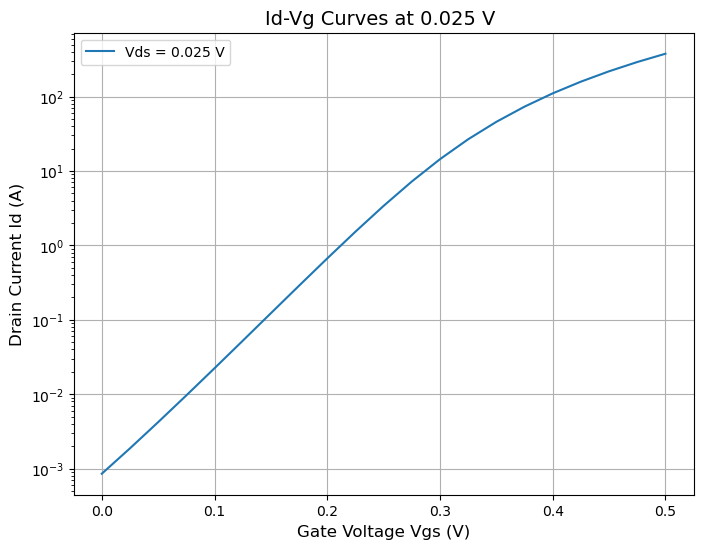

In [ ]:
selected_Vds = [0.025]  # Choose specific Vds values to plot
VV = 21  
Vgs = np.linspace(0.0, 0.5, VV)  # Gate-source voltage sweep (V)
Vds = np.linspace(0.0, 0.5, VV)  # Drain-source voltage sweep (V)

II = solver_instance.ds.II

Vg = np.linspace(0.0, 0.5, VV)
current = II[0, :]
current_diff = np.gradient(Vg, np.log10(current * 10e-9)) 
print(current_diff)
plt.figure(figsize=(8, 6))
plt.plot(Vg, current, label=f"Vds = {0.025:.3f} V")
plt.yscale("log")    

plt.xlabel("Gate Voltage Vgs (V)", fontsize=12)
plt.ylabel("Drain Current Id (A)", fontsize=12)
plt.title("Id-Vg Curves at 0.025 V ", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ham